# notebook to measure peak laser power with wand, aquires very fast from NI card using continuous analog aquisition. Contains very useful 'analog_listener' class.

In [1]:
import win32com.client
from datetime import date
import numpy as np
import time
from os import listdir
from os.path import isfile, join
import random
import fnmatch
import nidaqmx
import nidaqmx.stream_readers as stream_readers
import matplotlib.pyplot as plt
from lxml import etree
from mpl_toolkits.mplot3d import axes3d
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors
from scipy.optimize import curve_fit
from scipy.stats import linregress
import visa
from ThorlabsPM100 import ThorlabsPM100
%matplotlib notebook

ModuleNotFoundError: No module named 'win32com'

In [6]:
class analog_listener:
    
    def __init__(channels_list,file_path,sampling_rate=10000):
        # set up NI card to write for acquisition_time into a TDMS file
        self.num_channels = len(channels_list)

        # create list of task and channel objects
        self.tasks_list = []
        self.channel_list = []

        # create task
        self.task = nidaqmx.Task(new_task_name="python_task")

        # add every channel in the given channel list to task
        for i in range(num_channels):
            self.task.ai_channels.add_ai_voltage_chan(channels_list[i])

        # set task sampling rate and sample mode
        self.task.timing.cfg_samp_clk_timing(sampling_rate, sample_mode=AcquisitionType.CONTINUOUS)

        # add an input stream to the task
        self.input_stream = nidaqmx._task_modules.in_stream.InStream(task)

        # set input stream to write directly into TDMS file on the disk
        self.input_stream.configure_logging(file_path, logging_mode=nidaqmx.constants.LoggingMode.LOG)
    
    
    def measure(self,acquisition_time):
        # start the task
        self.task.start()

        # wait till acquisition time is over
        time.sleep(acquisition_time)

        # stop the task and close it to stop allocating the NI card
        self.task.stop()
        self.task.close()

        # read file in python and return the data as a numpy array
        tdms_file = nptdms.TdmsFile(self.file_path)

        # create data list
        data_list = []

        # fill data list with data written into DTMS file
        for i in range(self.num_devices):
            channel_object = tdms_file.object("python_task", self.devices_list[i])
            data_list.append(channel_object.data)

        # return a list of data arrays for every channel, should have identical length
        return data_list

In [3]:
def change_values(xml_file,elem_tags,elem_attrib_dicts):
    """
    changes values in a parsed xml file
    will iterate simultaneously through a list of elem_tags and a list of elem_attrib_dicts,
    with one dictionary for every tag.
    will replace according to an {attrib:value} structure
    elem_tags and elem_attrib_dicts need to have matching length and indices!
    """
    tree = etree.parse(xml_file)
    
    for elem in tree.iter():
        if elem.tag in elem_tags:
            index = elem_tags.index(elem.tag)
            for key in elem_attrib_dicts[index]:
                elem.attrib[key] = elem_attrib_dicts[index][key]
    
    tree.write(xml_file)

In [7]:
class AnalogPowerMeasurer:
    """
    This class takes analog devices on an AI card, a usb connection to the power meters, 
    a PrairieLink, and xmls and gpls to define the SLM experiment.
    It then fires the experiment once to find the best power range, 
    initializes the analog devices, starts the SLM experiments and listens to the analog inputs.
    returns a power range array and the analog input array."""
    
    def __init__(self,prairie_link, visa_resource_manager, power_meter_list):
        
        # store configruation
        self.pl = prairie_link
        self.rm = visa_resource_manager
        self.num_power_meters = len(power_meter_list)
        
        # create power_meters
        self.instruments = []
        self.power_meters = []
        for i in range(self.num_power_meters):
            self.instruments.append(rm.open_resource(power_meter_list[i]))
            self.power_meters.append(ThorlabsPM100(inst=self.instruments[i]))
        
        self.analog_listener = analog_listener(analog_channels_list,file_path,sampling_rate)
        
    def measure(self,xml_file,gpl_file,analog_channels_list,acquisition_time,file_path,sampling_rate=10000):
        self.pl.SendScriptCommands('-LoadMarkPoints ' + gpl_file + " True")
        self.pl.SendScriptCommands('-LoadMarkPoints ' + xml_file)
        
        for i in range(self.num_power_meters):
            self.power_meters[i].sense.power.dc.range.auto = "ON"
            pl.SendScriptCommands('-MarkPoints')
            pl.SendScriptCommands('-WaitForScan')
            time.sleep(0.5)
            self.power_meters[i].sense.power.dc.range.auto = "OFF"
            power_ranges[i] = self.power_meters[i].sense.power.dc.range
        
        pl.SendScriptCommands('-MarkPoints')
        data_list = self.analog_listener.measure(acquisition_time)
        
        return power_ranges, data

In [8]:
class DigitalPowerMeasurer:
    """
    This class takes analog devices on an AI card, a usb connection to the power meters, 
    a PrairieLink, and xmls and gpls to definethe SLM experiment.
    It then fires the experiment once to find the best power range, 
    initializes the analog devices, starts the SLM experiments and listens to the analog inputs.
    returns a power range array and the analog input array."""
    
    def __init__(self,prairie_link, visa_resource_manager, analog_channels_list, power_meter_list):
        
        # store configruation
        self.pl = prairie_link
        self.rm = visa_resource_manager
        self.num_power_meters = len(power_meter_list)
        
        # create power_meters
        self.instruments = []
        self.power_meters = []
        for i in range(self.num_power_meters):
            self.instruments.append(rm.open_resource(power_meter_list[i]))
            self.power_meters.append(ThorlabsPM100(inst=self.instruments[i]))
        
    def measure(self,power_dictionary,window_length=3):
        """
        take {laser_name:laser_power[PV]} dictionary and perform measurement with this power for 3s"""
        
        voltage_dictionary = {}
        
        for laser_name in power_dictionary.keys():
            pl.SendScriptCommands('-SetLaserPower ' + laser_name + ' ' + str(power_dictionary[laser_name]))
            time.sleep(window_length)
            voltage_dictionary[laser_name] = self.power_meters[i].read
            pl.SendScriptCommands('-SetLaserPower ' + laser_name + ' ' + str(0))
        
        return voltage_dictionary

In [12]:
# Start PrairieLink
pl = win32com.client.Dispatch('PrairieLink.Application')
print('object created')

# Connect to Client
pl.Connect()
print(pl.Connected)

object created
<bound method Connected of <COMObject PrairieLink.Application>>


In [13]:
# set the NI card channels that the power meters are connected to
analog_devices = ["Dev5/ai0"]

In [14]:
# configure gpl & xml files with element tags to replace
gpl = r"F:\Data\mloidolt\2018-08-29\AnalogPowerMeasurements\Grid.gpl"
gpl_elem_tags = ['PVGalvoPointGrid']

xml = r"F:\Data\mloidolt\2018-08-29\AnalogPowerMeasurements\Grid.xml"
xml_elem_tags = ['PVMarkPointElement','PVGalvoPointElement']

In [15]:
# configure linspaces of pulse durations and laser powers


In [18]:
# iterate through linspaces, build dictionaries, change files, reload them, fire and measure voltages

# Put Laser power here, duration does not matter
#elem_attrib_dicts = [{'UncagingLaserPower':"600",'Duration':"200"}]

#change_values(gpl,gpl_elem_tags,elem_attrib_dicts)

# put LaserPower=2 here because it's the second lser or something like that, true duration in ms
elem_attrib_dicts = [{'UncagingLaserPower':"5"},{'Duration':"1000"}]

change_values(xml,xml_elem_tags,elem_attrib_dicts)

In [19]:
pl.SendScriptCommands('-LoadMarkPoints ' + gpl + " True")
pl.SendScriptCommands('-LoadMarkPoints ' + xml)

True

In [23]:
durations = [30000]*5
powers = np.flip(np.arange(0.5,5.5,0.5),0)

print(durations)
print(powers)

[30000, 30000, 30000, 30000, 30000]
[5.  4.5 4.  3.5 3.  2.5 2.  1.5 1.  0.5]


In [24]:
num_durations = len(durations)
num_powers = len(powers)
num_samples = 512
num_channels = 2
num_windows = 500

data = np.zeros((num_durations,num_windows,num_channels,num_samples))
times = np.zeros(num_durations)

for i in range(num_durations):
    elem_attrib_dicts = [{'UncagingLaserPower':"{}".format(str(5))},{'Duration':"{}".format(str(durations[i]))}]
    change_values(xml,xml_elem_tags,elem_attrib_dicts)
    pl.SendScriptCommands('-LoadMarkPoints ' + xml)
    #print(elem_attrib_dicts
    pl.SendScriptCommands('-MarkPoints')
    t0 = time.time()
    data[i] = listener.listen(num_windows)
    t1 = time.time()
    times[i] = t1 - t0
    time.sleep(60)
    
    
np.save(r"F:\Data\mloidolt\2018-08-29\AnalogPowerMeasurements\2018-08-29_10s_MultiMeasurement",data)
np.save(r"F:\Data\mloidolt\2018-08-29\AnalogPowerMeasurements\2018-08-29_10s_MultiMeasurementTimes",times)

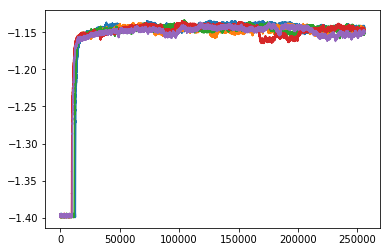

In [26]:
for i in range(5):
    plt.plot(data[i,:,0,:].ravel())

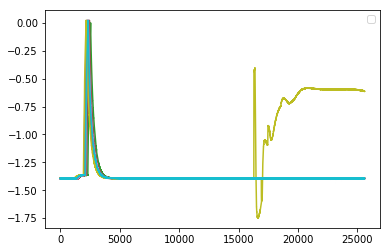

In [25]:
# view the results
#data = np.load('UncagingPath550.npy')

def normalize(X):
    return (X - np.min(X)) / (np.max(X) - np.min(X))

def model(t,tau,onset,scale):
    return np.heaviside(t - onset,0.5) * scale *(1 - np.exp((t-onset)/tau))

reshaped_data = data[:,:,0,:].reshape((num_durations,512*50))
normalized_data = np.copy(reshaped_data)
for i in range(num_durations):
    normalized_data[i] = normalize(reshaped_data[i])
#X = np.arange(len(Y))

guess = (-80000,-50000,1)

#popt, pcov = curve_fit(model,X,Y,guess)
#print(popt)
#print(pcov)

#plt.plot(X,model(X,*popt))

#plt.plot(data[:,0,:].flatten(),label='ai0')
for i in range(num_durations):
    plt.plot(reshaped_data[i])
plt.legend()
#np.save('UncagingPath600.npy',data)
#np.save('UncagingFitValues600.npy',popt)
#np.save('UncagingFitCov600.npy',pcov)

172.96794070292177
8.472441726271233
5.5420876685420835
5.16374469643505
9.061078975477754
6.766656822927638
7.356057228573464
8.70205109062951
5.795873473834221
4.810699774394306
6.470074220331964
-6504.999260971982
-6335.3532832515575
-6252.945208897556
-6404.33205398509
-6299.226690901981
-6427.884799225804
-6560.245706933041
-6379.918488468413
-6905.70480575151
-6749.708397208045
-6349.395054931546


<IPython.core.display.Javascript object>


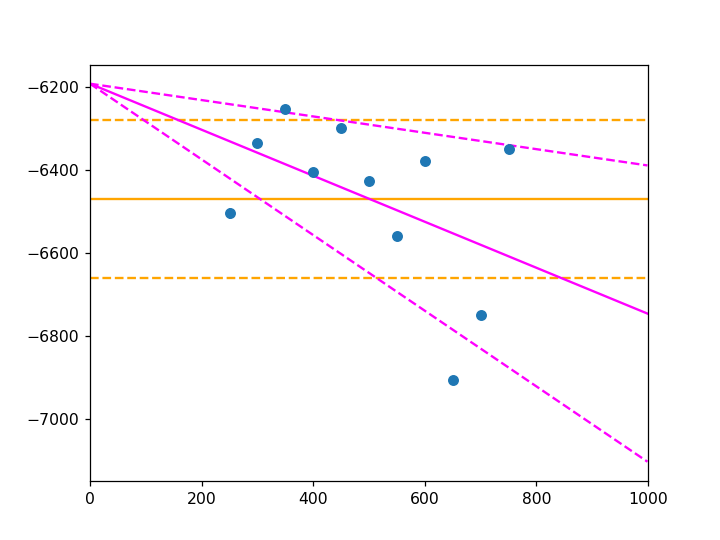

-0.45944252181516493 0.15512342534921447


(0, 1000)

In [144]:
taus = []
tau_errs = []

# define pattern that will be matched
pattern1 = 'UncagingFitValues*'
pattern2 = 'UncagingFitCov*'

# get list of files in current folder
list_of_files = listdir('.')

# construct list of all xmls in current folder

for f in list_of_files:
    if fnmatch.fnmatch(f, pattern1):
        content = np.load(f)
        print(content[0])
        taus.append(content[0])
    if fnmatch.fnmatch(f, pattern2):
        content = np.load(f)
        print(content[0,0])
        tau_errs.append(np.sqrt(content[0,0]))

PVs = np.arange(250,750+50,50)

plt.errorbar(PVs,taus,yerr=tau_errs,marker='o',linestyle='None')
tau = np.mean(taus)
std = np.std(taus)
plt.axhline(tau,color='orange')
plt.axhline(tau-std,color='orange',linestyle='--')
plt.axhline(tau+std,color='orange',linestyle='--')

slope, intercept, r_value, p_value, std_err = linregress(PVs, np.asarray(taus))
print(r_value, p_value)
PVs = np.arange(0,1000)

plt.plot(PVs,PVs*slope + intercept,color='magenta')
plt.plot(PVs,PVs*(slope-std_err) + intercept,color='magenta',linestyle='--')
plt.plot(PVs,PVs*(slope+std_err) + intercept,color='magenta',linestyle='--')

plt.xlim(0,1000)

(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)
(51200,)


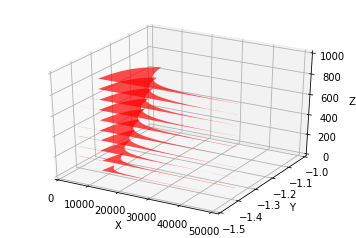